In [3]:
# import libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [10]:
def generate_network():
    """
    generate the network used within the simulation model
    returns a multi directed graph which includes bridges and intersections between roads
    """
    # import data
    df = pd.read_csv('../data/bridges_intersected_linked.csv')
    # drop old id
    df = df.drop("id", axis='columns')
    # sort roads dataframe based on road name and chainage
    df = df.sort_values(by=['road', 'km'])
    # reset index
    df = df.reset_index(drop=False)
    # set new index as ID
    df.rename(columns={'index': 'id'}, inplace=True)
    # retrieve all roads in dataset
    roads = df['road'].unique().tolist()
    # initialise the graph
    G = nx.DiGraph()
    # for each road in list roads
    for road in roads:
        road_subset = df[df['road'] == road]
        for index, row in df.iterrows():
            G.add_node(row['id'], pos=(row['lat'], row['lon']), len=row['length'],
                            typ=row['model_type'], road=row['road'], intersec=row['intersec_to'],
                            km=row['km'])
        # retrieve all edges between bridges for one road
        edges = [(index, index + 1) for index, row in road_subset.iterrows()]
        # remove last one, which is out of bound
        edges.pop()
        # reverse subset
        road_subset_reversed = road_subset.iloc[::-1]
        # get all reversed indexes and add to list of edges
        edges += [(index, index - 1) for index, row in road_subset_reversed.iterrows()]
        # remove last one, which is out of bound
        edges.pop()
        # add all edges
        G.add_edges_from(edges)

    # get model type of all nodes
    typ = nx.get_node_attributes(G, 'typ')
    # get road which is intersected with N1 or N2
    intersec_to = nx.get_node_attributes(G, 'intersec')
    # get current roads
    road = nx.get_node_attributes(G, 'road')
    # get all key, value pairs in dictionaries
    for key_typ, value_typ in typ.items():
        # if value equals intersection as model type
        if value_typ == 'intersection':
            # current road
            current_road = road[key_typ]
            # get road name which intersects N1 or N2
            intersected_road = intersec_to[key_typ]
            # get subset of intersected road
            subset_intersected_road = df[df['road'] == intersected_road]
            # get all rows which are intersections
            intersections = subset_intersected_road[subset_intersected_road['model_type'] == 'intersection']
            # select the row for which intersection to equals current road
            row = intersections[intersections['intersec_to'] == current_road]
            # retrieve ID
            row_index = row.index[0]
            # assign intersected edge to variable
            if (key_typ, row_index) not in G.edges:
                # add intersected edge
                G.add_edge(key_typ, row_index, distance=0)

    # retrieve the chainage of every node
    chainage = nx.get_node_attributes(G, 'km')
    # for each edge pair
    for u, v in G.edges:
        # if difference between node values equals one i.e. not an intersected edge
        if abs(v - u) == 1:
            # compute the distance based on difference in chainage, take absolute value
            distance = abs(chainage[v] - chainage[u])
            # multiply to retrieve kilometers rather than meters
            distance *= 1000
            # add to edge as distance attribute
            G[u][v]['distance'] = distance

    # return network
    return G

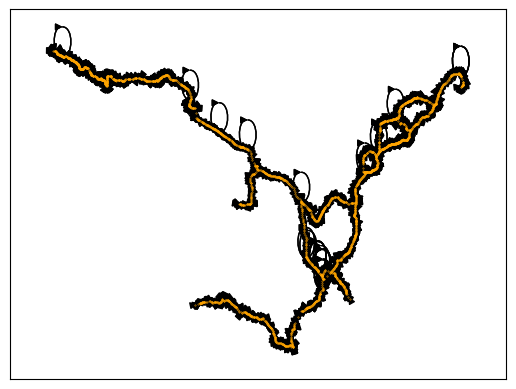

In [15]:
network = generate_network()
pos = nx.get_node_attributes(network, 'pos')
nx.draw_networkx(network, pos=pos, arrows=None, with_labels=False, node_size = 0.1, node_color = 'orange')
plt.savefig('../img/road_network.png')
plt.show()